In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pyccl as ccl
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import CubicSpline

import sys
import os
sys.path.insert(0, os.path.abspath('../src'))

from wale.CosmologyModel import *
from wale.CovarianceMatrix import *
from wale.InitializeVariables import *
from wale.VarianceCalculator import *
from wale.FilterFunctions import *
from wale.CommonUtils import *
from wale.CriticalPoints import *
from wale.ComputePDF import *
from wale.LoadSimulations import *

import cProfile, pstats


In [2]:
cosmotable = np.loadtxt('../data/CosmoTable.dat')
cosmotable_om = cosmotable[:,1]
cosmotable_h = cosmotable[:,2]
cosmotable_w0 = cosmotable[:,3]
cosmotable_sig8 =  cosmotable[:,4]
cosmotable_oc = cosmotable[:,5]

# Define parameter bounds based on min and max values
param_bounds = np.array([
    [np.min(cosmotable_om), cosmotable_om.max()],
    [cosmotable_h.min(), cosmotable_h.max()],
    [cosmotable_w0.min(), cosmotable_w0.max()],
    [cosmotable_sig8.min(), cosmotable_sig8.max()],
    [cosmotable_oc.min(), cosmotable_oc.max()]
])

lh_df = pd.DataFrame(cosmotable[:,1:], columns=["Om", "h", "w0", "sig8", "Oc"])

cosmotable_new = np.loadtxt('../data/lhs_cosmo_samples_halofit.dat')
cosmotable_om_new = cosmotable_new[:,0]
cosmotable_h_new = cosmotable_new[:,1]
cosmotable_w0_new = cosmotable_new[:,2]
cosmotable_sig8_new =  cosmotable_new[:,3]
# cosmotable_oc = cosmotable[:,5]


lh_df_new = pd.DataFrame(cosmotable_new[:,:], columns=["Om", "h", "w0", "sig8"])

# print(lh_df.T)

Text(0, 0.5, '$w_0$')

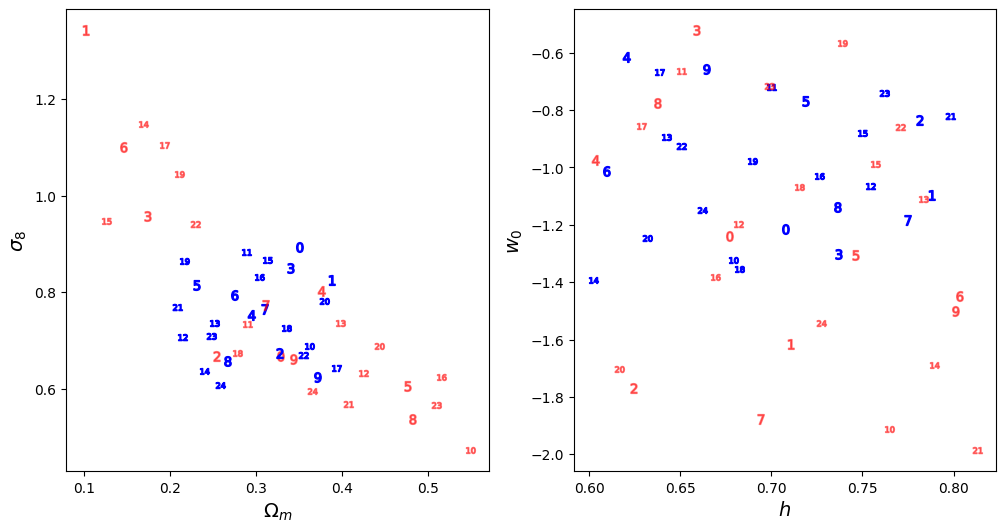

In [3]:
marker = np.arange(0, 25, 1)
fig, axs = plt.subplots(1,2, figsize=(12, 6))
plt.subplot(1,2,1)
for i in range(len(lh_df_new)):
        axs[0].scatter(lh_df_new["Om"][i], lh_df_new["sig8"][i], color='blue', marker=f"${marker[i]}$", s=50)
        axs[0].scatter(lh_df["Om"][i], lh_df["sig8"][i], color='red', s=50, marker=f"${marker[i]}$", alpha=0.5)
        axs[1].scatter(lh_df_new["h"][i], lh_df_new["w0"][i], color='blue', marker=f"${marker[i]}$", s=50)
        axs[1].scatter(lh_df["h"][i], lh_df["w0"][i], color='red', s=50, marker=f"${marker[i]}$", alpha=0.5)
axs[0].set_xlabel(r"$\Omega_m$", fontsize=14)
axs[0].set_ylabel(r"$\sigma_8$", fontsize=14)
axs[1].set_xlabel(r"$h$", fontsize=14)
axs[1].set_ylabel(r"$w_0$", fontsize=14)

       
    

In [4]:
import distinctipy

num_colors = 25
distinct_colours = distinctipy.get_colors(num_colors, pastel_factor=0.7)

# 2. Choose a darkening factor (e.g., 0.8 for 20% darker)
darkening_factor = 0.8

# 3. Scale each color’s RGB channels
dark_colours = [
    (r * darkening_factor, g * darkening_factor, b * darkening_factor)
    for r, g, b in distinct_colours
]

# plt.scatter(np.linspace(0, 1, len(distinct_colours)), np.zeros(len(distinct_colours)), c=distinct_colours, s=100)
# # 4. Plot to verify
# plt.figure(figsize=(8, 2))
# plt.scatter(
#     np.linspace(0, 1, num_colors),
#     np.zeros(num_colors),
#     c=dark_colours,
#     s=100
# )
# plt.yticks([])
# plt.xlim(-0.05, 1.05)
# plt.title("Slightly Darkened Palette")
# plt.show()

In [5]:
results_fin = {}

In [6]:
def get_results(cosmo_index,tomo_bin, edges, centers, snr,theta1,R_pixels, filter_type,nz_file, simulation):
    results={}
    # --- Simulation block ---
    print(f"\n Processing cosmology index: {cosmo_index}")
    if simulation:
        sim_l1_runs, sim_pdf_runs, avg_sim_l1, std_sim_l1, avg_sim_pdf, std_sim_pdf, simvar = \
            get_simulation_l1(
                cosmo_index,
                tomo_bin,
                edges,
                centers,
                snr,
                R_pixels=R_pixels,
                filter_type=filter_type,
                plot=False,
            )
    else:
        sim_l1_runs = sim_pdf_runs = avg_sim_l1 = std_sim_l1 = avg_sim_pdf = std_sim_pdf = simvar = None
        
    if simulation:
        # --- Cosmology parameters ---
        h = lh_df['h'].iloc[cosmo_index]
        Oc = lh_df['Oc'].iloc[cosmo_index]
        Ob = 0.043
        w = lh_df['w0'].iloc[cosmo_index]
        wa = 0.0
        sigma8 = lh_df['sig8'].iloc[cosmo_index]
        Om = lh_df['Om'].iloc[cosmo_index]
    else:
        # --- Cosmology parameters ---
        h = lh_df_new['h'].iloc[cosmo_index]
        Om = lh_df_new['Om'].iloc[cosmo_index]
        Ob = 0.043
        Oc = Om - Ob #lh_df_new['Oc'].iloc[cosmo_index]
    
        w = lh_df_new['w0'].iloc[cosmo_index]
        wa = 0.0
        sigma8 = lh_df_new['sig8'].iloc[cosmo_index]
    

    variables = InitialiseVariables(
        h=h, Oc=Oc, Ob=Ob, w=w, wa=wa, sigma8=sigma8,
        dk=0.005, kmin=1e-4, kmax=1,
        nz_file=nz_file, variability=False,
        theta1=theta1, nplanes=8
    )

    # Compute sigma^2 maps
    variance = Variance(variables.cosmo, filter_type=filter_type, pk=variables.cosmo.pnl)
    variables.sigmasq_map = np.sum(
        variables.dchi * (variables.lensingweights ** 2) * np.array([
            variance.get_sig_slice(z, chi * variables.theta1_radian, chi * variables.theta2_radian)
            for z, chi in zip(variables.redshifts, variables.chis)
        ])
    )

    # Theory (perturbation) sigma^2
    theory_sigmasq = compute_sigma_kappa_squared(
        theta1, variables.chis, variables.lensingweights,
        variables.redshifts, variables.cosmo.k, variables.cosmo.pnl,
        filter_type=filter_type, h=h
    )
    
    variables.recal_value = variables.sigmasq_map / theory_sigmasq
        
    print(f"  The ldt variance is: {variables.sigmasq_map}")
    print(f"  The perturbation theory variance is: {theory_sigmasq}") 
    if simulation:
        print(f"   The simulation variance is: {np.mean(simvar)}")
    print(f"   The recalibration factor is: {variables.recal_value}")
            
    # Critical points and lambdas
    smallest_positive, largest_negative = find_critical_points_for_cosmo(
        variables, variance, ngrid_critical=30, plot=False, min_z=0, max_z=3
    )
    if smallest_positive and largest_negative is not None:
        variables.lambdas = np.linspace(largest_negative, smallest_positive, 20)
    else:
        variables.lambdas = np.linspace(-450, 700, 20) #tomo5
        variables.lambdas = np.linspace(-700, 800, 20) #tomo4
    if simulation and cosmo_index == 11 and tomo_bin == 5:
        variables.lambdas = np.linspace(-550, 700, 20)
    if not simulation and cosmo_index == 3 and tomo_bin==5:
        variables.lambdas = np.linspace(-500, 700, 20)
    if not simulation and cosmo_index == 4 and tomo_bin==5:
        variables.lambdas = np.linspace(-750, 800, 20)
        
    # Compute PDF and L1
    computed_PDF = computePDF(variables, variance, plot_scgf=False)
    pdf_vals, kappa_vals = computed_PDF.pdf_values, computed_PDF.kappa_values
    norm_kappa = kappa_vals / np.sqrt(theory_sigmasq)
    prediction_pdf = CubicSpline(norm_kappa, pdf_vals)(snr)
    prediction_l1 = CubicSpline(norm_kappa, np.abs(kappa_vals) * pdf_vals)(snr)

    # Store results
    pred_stats = get_moments(snr * (theory_sigmasq**0.5), prediction_pdf)            
    print(f"  predstats: mean: {pred_stats[0]}, variance: {pred_stats[1]}, s3: {pred_stats[2]:.3f}, kurtosis: {pred_stats[3]:.3f}, norm: {pred_stats[4]:.3f}")
    entry = {
        'cosmo_index': cosmo_index,
        'cosmology': {'h': h, 'Oc': Oc, 'Om': Om, 'w': w, 'wa': wa, 'sigma8': sigma8},
        'snr': snr,
        'prediction_l1': prediction_l1,
        'ldt_theory_sigma_sq': variables.sigmasq_map,
        'perturbation_theory_sigma_sq': theory_sigmasq,
        'pred_stats': {
            'mean': pred_stats[0],
            'variance': pred_stats[1],
            's3': pred_stats[2],
            'kurtosis': pred_stats[3],
            'norm': pred_stats[4]
        }        
    }
    if simulation:
        sim_stats = get_moments(snr * (np.mean(simvar)**0.5), avg_sim_pdf)
        mean_sim, variance_sim, s3_sim, kurtosis_sim, norm_sim = sim_stats
        print(f"  simstats: mean: {mean_sim}, variance: {variance_sim}, s3: {s3_sim:.3f}, kurtosis: {kurtosis_sim:.3f}, norm: {norm_sim:.3f}")
        residual = (prediction_l1 - avg_sim_l1) / avg_sim_l1
        entry.update({
            'sim_pdf_runs': sim_pdf_runs,
            'sim_l1_runs': sim_l1_runs,
            'simvar': simvar,
            'residual': residual, 
            'sim_stats': {
                'mean': mean_sim,
                'variance': variance_sim,
                's3': s3_sim,
                'kurtosis': kurtosis_sim,
                'norm': norm_sim
            }
        })
    results[cosmo_index] = entry
    return results



 Processing cosmology index: 0

Initialised Cosmology:
  h = 0.707418, Oc = 0.30714400000000003, Ob = 0.043, w = -1.216086, wa = 0.0, sigma8 = 0.8927
  k-range: [0.0001, 1] with step dk = 0.005

   Initialised Variables:
      Source redshift: from nz file
      Number of planes: 8
      Angular scale theta1 (radians): 0.004363323129985824
      Variability: disabled
Variance module initialized...
  The ldt variance is: 2.685928555374868e-05
  The perturbation theory variance is: 2.41407473932187e-05
   The recalibration factor is: 1.1126120130519919
Finding critical points...
Setting ngrid = 30. Increase this for more accuracy, but note that computation becomes slower!
Smallest distance pair of critical points: 810.5949484508681 -348.81935557237296
The variance from PDF is:  2.4140787554209282e-05
  predstats: mean: 4.644538265921247e-09, variance: 2.4140610202299245e-05, s3: -26.016, kurtosis: 0.090, norm: 1.000


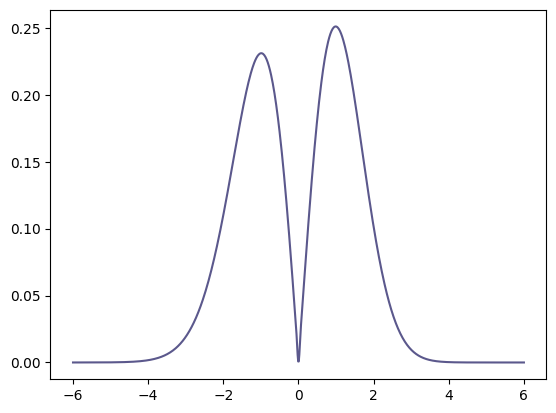

In [7]:
# --- User parameters ---
tomo_bin = 5
nz_file = f"../data/nz_arrays_bin{tomo_bin}.npy"

filter_type = 'tophat'

theta1 = 15
R_pixels = int(theta1 / 0.5)
edges = np.linspace(-0.06, 0.06, 401)
centers = 0.5 * (edges[:-1] + edges[1:])
snr = np.linspace(-6, 6, 800)

# Flag: include simulation results
simulation = False  # Set to False to disable simulation data

# Container for results
results = {}
def main():
    results = {}
    # Loop through each cosmology index
    for cosmo_index in range(0,1):
        results.update(get_results(cosmo_index, tomo_bin, edges, centers, snr, theta1, R_pixels, filter_type, nz_file, simulation=simulation))  
        plt.plot(snr, results[cosmo_index]['prediction_l1'], label=f"Cosmo {cosmo_index}", color=dark_colours[cosmo_index])
        if simulation:
            plt.errorbar(snr[::4], np.mean(results[cosmo_index]['sim_l1_runs'], axis=0)[::4], yerr= np.std(results[cosmo_index]['sim_l1_runs'], axis=0)[::4],color=dark_colours[cosmo_index], fmt='o', markersize=2, label=f"Sim {cosmo_index}")
    return results
    
if __name__ == '__main__':
    key = f"filter{filter_type}_results_{theta1}_tomobin{tomo_bin}_simulation{simulation}"
          # or an existing dict
    results_fin[key] = main()

# np.save(key, results_fin[key], allow_pickle=True)